In [19]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.special import boxcox1p
import pickle
from os import path
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

# data Visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.express as px 
from plotnine import ggplot, aes, geom_line, geom_point, facet_wrap, theme
import plotly.graph_objects as go
# Machine learning algorithms and model evaluation
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from skforecast.model_selection import backtesting_forecaster
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from lightgbm import LGBMRegressor
# Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


1. Data Preprocessing:
Load the datasets


In [20]:
# Load the three datasets
average_hours = pd.read_csv('Resources/average-usual-weekly-hours-worked-women-15-years-and-older.csv')
employment_ratio = pd.read_csv("Resources/female-employment-to-population-ratio.csv")
wage_gap = pd.read_csv("Resources/gender-wage-gap-oecd.csv")


1. Data Preprocessing: Rename Columns to make it shorter

In [21]:
average_hours = average_hours.rename(columns={'Average weekly hours worked (women, 15+) (OECD Labor Force Statistics (2017))': 'Avg_Hours_Worked'})
average_hours.head()

,Entity,Code,Year,Avg_Hours_Worked
0,Australia,AUS,2001,31.062685
1,Australia,AUS,2002,30.964121
2,Australia,AUS,2003,30.929489
3,Australia,AUS,2004,31.107463
4,Australia,AUS,2005,31.109187


In [22]:
employment_ratio = employment_ratio.rename(columns={'Employment to population ratio, 15+, female (%) (national estimate)': 'Emp_Pop_Ratio'})
employment_ratio.head()

,Entity,Code,Year,Emp_Pop_Ratio
0,Afghanistan,AFG,2008,42.832
1,Afghanistan,AFG,2012,15.481
2,Afghanistan,AFG,2014,23.177
3,Afghanistan,AFG,2017,18.202
4,Afghanistan,AFG,2020,13.730


In [23]:
wage_gap = wage_gap.rename(columns={'Gender wage gap (OECD 2017)': 'Gender_Wage_Gap'})
wage_gap.head()

,Entity,Code,Year,Gender_Wage_Gap
0,Australia,AUS,1975,21.6
1,Australia,AUS,1976,20.8
2,Australia,AUS,1977,18.4
3,Australia,AUS,1978,19.8
4,Australia,AUS,1979,20.0


1. Data Preprocessing: Check datatypes for each of the dataset columns.

In [24]:
# Check the data types of the columns
average_hours.dtypes
print("average_hours columns:", average_hours.dtypes)
employment_ratio.dtypes
print("average_hours columns:", employment_ratio.dtypes)
wage_gap.dtypes
print("average_hours columns:", wage_gap.dtypes)

average_hours columns: Entity               object
Code                 object
Year                  int64
Avg_Hours_Worked    float64
dtype: object
average_hours columns: Entity            object
Code              object
Year               int64
Emp_Pop_Ratio    float64
dtype: object
average_hours columns: Entity              object
Code                object
Year                 int64
Gender_Wage_Gap    float64
dtype: object


In [30]:
# Merge the three datasets 
merged_df = pd.merge(average_hours, employment_ratio, on=['Entity', 'Code', 'Year'], how='outer')
merged_df = pd.merge(merged_df, wage_gap, on=['Entity', 'Code', 'Year'], how='outer')


In [32]:
# Check for null values
print(merged_df.isnull().sum())

Entity                 0
Code                 318
Year                   0
Avg_Hours_Worked    3060
Emp_Pop_Ratio        112
Gender_Wage_Gap     3395
dtype: int64


In [34]:
# Drop rows with null values
merged_df.dropna(inplace=True)
print(merged_df.isnull().sum())

Entity              0
Code                0
Year                0
Avg_Hours_Worked    0
Emp_Pop_Ratio       0
Gender_Wage_Gap     0
dtype: int64


In [35]:
# Check for duplicates
duplicates = merged_df.duplicated().sum()
print(f"Number of duplicates: {duplicates}")

Number of duplicates: 0


In [36]:
# Check the data types of each column
print(merged_df.dtypes)


Entity               object
Code                 object
Year                  int64
Avg_Hours_Worked    float64
Emp_Pop_Ratio       float64
Gender_Wage_Gap     float64
dtype: object


In [37]:
# Perform some basic EDA
print(merged_df.describe())
print(merged_df.head())
print(merged_df.info())

              Year  Avg_Hours_Worked  Emp_Pop_Ratio  Gender_Wage_Gap
count   383.000000        383.000000     383.000000       383.000000
mean   2006.362924         34.427762      49.250308        14.754047
std       6.462245          3.621710       9.111986         6.945150
min    1983.000000         24.323804      20.960000         0.000000
25%    2003.000000         31.356161      43.347000         9.850000
50%    2007.000000         33.747847      49.238000        15.000000
75%    2011.000000         38.041559      53.946000        19.200000
max    2016.000000         44.813507      76.439000        35.100000
        Entity Code  Year  Avg_Hours_Worked  Emp_Pop_Ratio  Gender_Wage_Gap
118  Australia  AUS  2001         31.062685         51.520             14.3
119  Australia  AUS  2002         30.964121         51.862             15.0
120  Australia  AUS  2003         30.929489         52.593             13.0
121  Australia  AUS  2004         31.107463         52.622             14.4

In [38]:
# Check for outliers in numerical columns
numerical_cols = merged_df.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    Q1 = merged_df[col].quantile(0.25)
    Q3 = merged_df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = merged_df[(merged_df[col] < Q1 - 1.5 * IQR) | (merged_df[col] > Q3 + 1.5 * IQR)]
    print(f"Outliers in column {col}: {outliers.shape[0]}")


Outliers in column Year: 11
Outliers in column Avg_Hours_Worked: 0
Outliers in column Emp_Pop_Ratio: 14
Outliers in column Gender_Wage_Gap: 7


In [58]:
from sklearn.preprocessing import LabelEncoder

# Assume 'country' is your categorical feature
country_encoder = LabelEncoder()
merged_df['Entity'] = country_encoder.fit_transform(merged_df['Entity'])


matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
matplotlib.category INFO  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


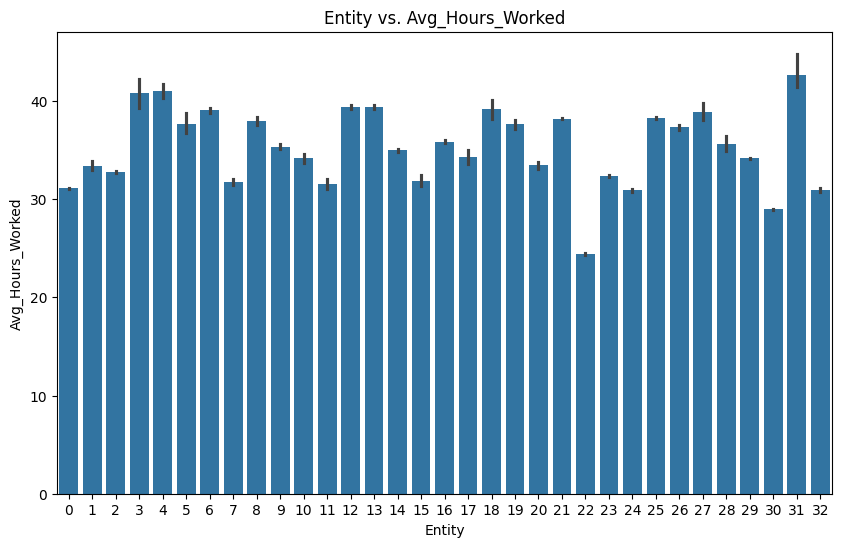

In [59]:
# 1. Bar chart: Entity vs. average_hours
plt.figure(figsize=(10, 6))
sns.barplot(x='Entity', y='Avg_Hours_Worked', data=merged_df)
plt.title('Entity vs. Avg_Hours_Worked')
plt.show()


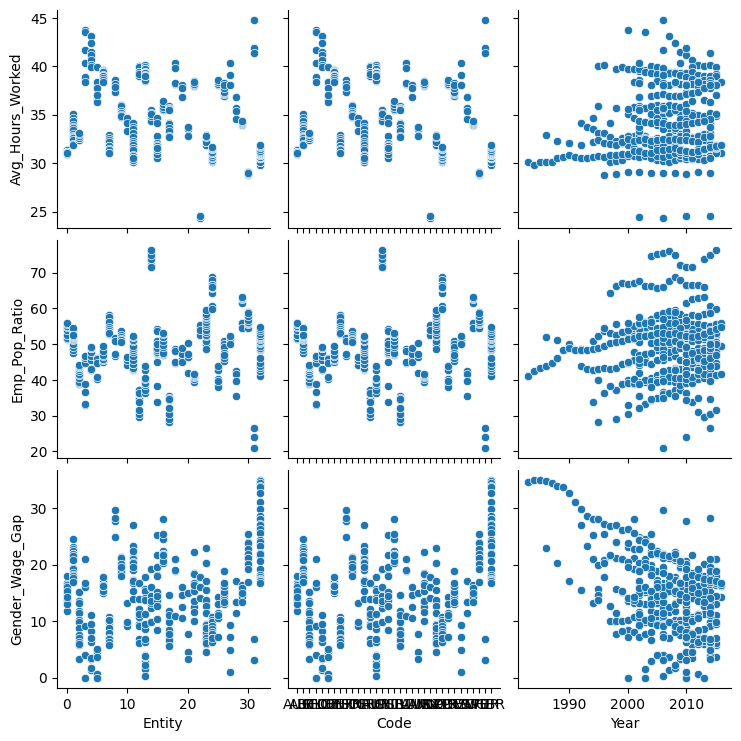

In [60]:
# Visualize the data
import matplotlib.pyplot as plt
import seaborn as sns
sns.pairplot(merged_df, x_vars=['Entity', 'Code', 'Year'], y_vars=['Avg_Hours_Worked', 'Emp_Pop_Ratio', 'Gender_Wage_Gap'])
plt.show()

Model 1: Linear Regression

In [61]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Define the feature and target variables
X = merged_df[['Avg_Hours_Worked', 'Emp_Pop_Ratio', "Gender_Wage_Gap"]]
y = merged_df['Entity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = lr_model.predict(X_test)

# Evaluate the model using mean squared error (MSE)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse:.2f}')

MSE: 106.40


Model 2: Decision Tree Regressor

In [62]:
from sklearn.tree import DecisionTreeRegressor

# Define the feature and target variables
X = merged_df[['Avg_Hours_Worked', 'Emp_Pop_Ratio', "Gender_Wage_Gap"]]
y = merged_df['Entity']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a decision tree regressor model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = dt_model.predict(X_test)

# Evaluate the model using mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse:.2f}')

MSE: 67.29
